# Análise de sentimentos

## Introdução

Como parte do desafio do trabalho semestral "Aprendizagem por Projetos Integrados (API)", a Hextech tem como meta implementar um sistema capaz de fornecer análises de sentimentos por meio de algoritmos de _Machine Learning_ (aprendizado de máquina). Os comentários escolhidos para serem analisados são avaliações de clientes de _e-commerces_ (lojas virtuais), oferecidos pela B2W Digital (grupo responsável pelas lojas Submarino, Shoptime e Americanas.com), e, para viabilizar a análise, vamos separá-los em três classes: "Positivos", "Neutros" e "Negativos".  
O objetivo final é compor um painel online de informações, que forneça _insights_ (percepções) sobre a satisfação desses clientes segmentando por estados do Brasil, construindo assim, uma ferramenta de análise poderosa para guiar decisões do _businesss_ (negócio) do cliente.  
Para isso utilizamos uma biblioteca de _Machine Learning_ chamada XGBoost, especificamente o modelo XGBClassifier.  
Aqui você encontrará todas as etapas realizadas para concluir esse desafio, com textos explicativos, códigos do projeto e gráficos para visualização de resultados.

## Índice
* [_Machine Learning_ (apredizado de máquina)](#machine-learning-aprendizado-de-máquina)
* [Base de dados](#base-de-dados)
* [Principais Bibliotecas](#principais-bibliotecas)
    * [Importação](#)
* [Carregamento da base de dados](#carregamento-da-base-de-dados)
* [Tratamento da base de dados](#tratamento-da-base-de-dados)
    * [Limpeza inicial](#limpeza-inicial)
    * [Classificação de comentários](#classificação-de-comentários)
    * [Balanceamento de classes](#balanceamento-de-classes)
    * [_Data augmentation_ (aumento de dados)](#data-augmentation-aumento-de-dados)
    * [Pré-processamento do texto](#pré-processamento-do-texto)
    * [Separação de dados](#separação-de-dados)
    * [Vetorização](#vetorização)
* [Treinamento de validação do modelo](#treinamento-e-validação-do-modelo)
* [Resultados](#resultados)
    * [Acurácia](#acurácia)
    * [Previsão das classes](#previsão-das-classes)
    * [Matriz de confusão](#matriz-de-confusão)
    * [Avaliação de performance](#avaliação-de-performance)
    * [Curva de ROC](#curva-de-roc)
    * [Melhoria dos resultados para classe 'Neutro'](#melhoria-dos-resultados-para-classe-neutro)
* [Exportação do modelo](#exportação-do-modelo)

## _Machine learning_ (aprendizado de máquina)
Como dito anteriormente, para viabilizar a análise de sentimentos dos comentários vamos trabalhar com _Machine learning_, mais especificamente com um modelo XGBoost. Abaixo estão alguns motivos que guiaram essa escolha:

1- Desempenho: esse modelo é conhecido por sua capacidade de fornecer um desempenho excepcional em uma ampla gama de conjuntos de dados. Ele é altamente otimizado e eficiente, o que o torna uma escolha ideal para lidar com grandes conjuntos de dados com muitas características.

2- Regularização: oferece várias técnicas de regularização, como regularização L1 e L2, que ajudam a evitar _overfitting_* e melhorar a generalização do modelo. Isso é especialmente importante em análise de sentimentos, onde o sobreajuste pode ser um problema comum devido à complexidade e subjetividade dos dados.

3- Flexibilidade: suporta uma variedade de funções de perda e métricas de avaliação, permitindo que você ajuste o modelo de acordo com os requisitos específicos do problema de análise de sentimentos. Além disso, possui fácil integração com outras bibliotecas e ferramentas populares de ciência de dados.

4- Interpretabilidade: embora seja um modelo complexo, XGBoost oferece certa interpretabilidade. Você pode visualizar a importância das características, o que ajuda a entender quais palavras ou características estão contribuindo mais para as previsões de sentimento.

<span style="font-size: smaller;">* _overfitting_: é como é chamado o estado de um modelo de _machine learning_ que se adaptou demais aos dados de treinamento, perdendo a capacidade de fazer previsões precisas em novos dados.</span>

## Base de dados
A base utilizada está disponível em [b2w-reviews01](https://github.com/americanas-tech/b2w-reviews01), em formato ```.csv```, e contém mais de 130 mil linhas de avaliações dos clientes sobre produtos adquiridos no site de varejo Americanas.com.  
Essa base conta com diversas informações sobre as compras avaliadas, e entre as mais importantes para nosso treinamento estão o texto do comentário (coluna '_review_text_'), a nota que reflete a satisfacação do cliente (coluna '_overall_rating_') e o estado do cliente que avaliou (coluna '_reviewer_state_'). Além disso, há outras informações como categoria do produto avaliado, marca etc. Também há mais informações dos clientes como sexo, ano de nascimento etc., com um complemento relacionado ao nível de satisfação, que indica a possível indicação dos produtos pelo cliente avaliador, e claro, a data de cada avaliação.

## Principais Bibliotecas

### XGBoost
XGBoost (_eXtreme Gradient Boosting_ ou Aprimoramento de Gradiente Extremo) é uma biblioteca de código aberto, amplamente utilizada em machine learning devido à sua eficiência e alto desempenho. Projetada para ser rápida e flexível, ela emprega técnicas avançadas de árvore de decisão para melhorar a precisão dos modelos. Em nosso projeto, estamos utilizando XGBoost para realizar a análise de sentimento em comentários de review de produtos.

### Pandas
A biblioteca pandas é essencial para a manipulação e análise de dados. Ela oferece estruturas de dados flexíveis, como _DataFrames_ (estrutura de dados tabulares), que são ideais para carregar, manipular e analisar grandes conjuntos de dados. No nosso projeto, pandas é utilizada para ler arquivos ```.csv```, explorar os dados e realizar operações de limpeza e transformação.

### NLTK
O NLTK (_Natural Language Toolkit_ ou Kit de Ferramentas de Linguagem Natural) é uma biblioteca poderosa para processamento de linguagem natural (PLN). Ela inclui ferramentas para _tokenização_\*, lematização e remoção de _stopwords\*_, que são fundamentais para a preparação de dados textuais. No nosso contexto de análise de sentimentos, o NLKT ajuda a transformar texto bruto em uma forma que pode ser analisada por algoritmos de _machine learning_ (aprendizado de máquina).

### sklearn (scikit-learn)
A biblioteca scikit-learn é uma ferramenta robusta para _machine learning_ em Python. Ela oferece vários módulos para dividir dados, criar modelos e avaliar sua performance.

### Matplotlib e seaborn
As bibliotecas Matplotlib e Seaborn são usadas para visualização de dados. Elas permitem criar gráficos e visualizações que ajudam a entender a distribuição dos dados e a performance do modelo.

### Joblib
Essa biblioteca é utilizada para serializar e desserializar objetos Python, como modelos de machine learning treinados. Isso permite salvar um modelo treinado em disco e carregá-lo posteriormente para fazer previsões.

<span style="font-size: smaller;">* _Tokenização_: o texto é dividido em _tokens_ (palavras individuais) para facilitar a lematização e a remoção de _stopwords_.</span><br>
<span style="font-size: smaller;">* _Stopwords_: palavras muito comuns em um idioma que são removidas durante o processamento de linguagem natural por não contribuírem significativamente para o significado do texto. Exemplos em português incluem "o", "a", "de", "para". Em inglês incluem "the", "is", "at".</span>

### Importação
Abaixo temos a importação das bibliotecas mencionadas para utilização no projeto.

In [1]:
# Importação das bibliotecas
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
import unicodedata
import xgboost as xgb
from joblib import dump
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Baixa os recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Carregamento da base de dados
Para iniciar o projeto fizemos a leitura e carregamento da base de dados (chamada de _dataset_) com a biblioteca Pandas: 

In [2]:
# Carrega o conjunto de dados
dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")

# Mostra o tamanho do dataset original
print("Tamanho original do dataset:", dataset.shape[0], "linhas,", dataset.shape[1], "colunas.")

Tamanho original do dataset: 132373 linhas, 14 colunas.


C:\Users\ghans\AppData\Local\Temp\ipykernel_14232\15791380.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")


## Tratamento da base de dados
Nessa etapa foram feitas uma série de etapas para limpar e tratar nossa base de dados, a fim de viabilizar um treinamento efetivo do modelo.

### Limpeza inicial

Foram removidas as linhas com valores nulos nas colunas de comentário (_review_text_) e nota da avaliação (_overall_rating_), o que garantiu não termos nenhum comentário sem nota da avaliação e nenhuma nota de avaliação sem comentário, já que ambas informações são necessárias para o treinamento.

In [3]:
# Remove linhas com valores em branco
dataset = dataset.dropna(subset=['review_text', 'overall_rating'])

# Mostra o tamanho do dataset alterado
print("Tamanho do dataset pós limpeza:", dataset.shape[0], "linhas,", dataset.shape[1], "colunas.")

Tamanho do dataset pós limpeza: 129098 linhas, 14 colunas.


### Classificação de comentários
Agora que limpamos, precisamos classificar os comentários para ter um rótulo dos nossos dados e assim tornar possível o treinamento. Para isso, criamos uma nova coluna chamada '_feeling_' (sentimentos), que armazenará uma das três opções: ```0```, ```1``` e ```2```, considerando que ```0``` representa comentários **negativos**, ```1``` representa comentários **neutros** e ```2``` representa comentários **positivos**. 
Essa atribuição foi feita com base na nota de cada avaliação, sendo comentários de avaliações com nota abaixo de 3 considerados como negativos, os com nota igual a 3 são neutros e com nota maior que 2, positivos. Lembrando que cada avaliação tem uma nota que varia de 0 a 5.

In [4]:
# Cria uma nova coluna para classificar entre comentários positivos(2), negativos(0) ou neutros(1) com base na nota:
dataset['feeling'] = np.where(dataset['overall_rating'] < 3, 0, np.where(dataset['overall_rating'] == 3, 1, 2))
dataset = dataset[['review_text', 'overall_rating', 'feeling']]
# Mostra os primeiros registros do dataset
print("Dataset com a nova coluna 'feeling':")
dataset

Dataset com a nova coluna 'feeling':


,review_text,overall_rating,feeling
0,Estou contente com a compra entrega rápida o ú...,4,2
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4,2
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4,2
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4,2
4,"A entrega foi no prazo, as americanas estão de...",5,2
...,...,...,...
132368,"Vale muito, estou usando no controle do Xbox e...",5,2
132369,"Prático e barato, super indico o produto para ...",5,2
132370,Chegou antes do prazo previsto e corresponde a...,4,2
132371,"Material fraco, poderia ser melhor. Ficou deve...",1,0


### Balanceamento de classes
Para melhor visualização da distribuição de classes ('Positivo', 'Neutro' e 'Negativo') fizemos aqui um balanceamento e exibição em gráfico do quanto cada uma delas representa no dataset, com as bibliotecas Seaborn e Matplotlib.

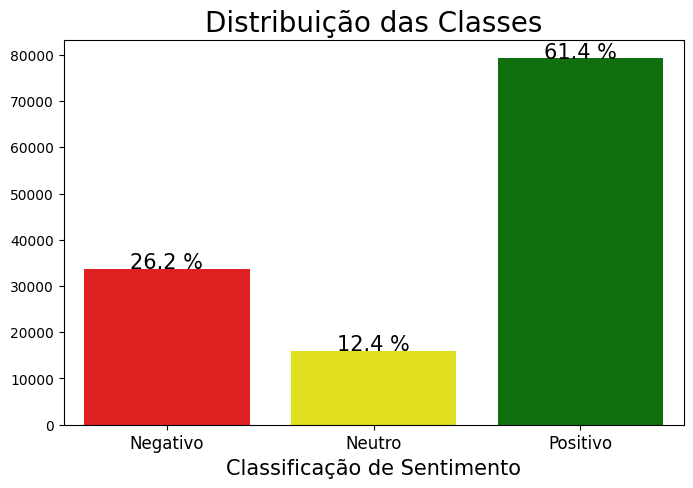

Distribuição Quantitativa:
 feeling
2    79316
0    33772
1    16010
Name: count, dtype: int64

Distribuição Percentual:
 feeling
2    0.614386
0    0.261600
1    0.124014
Name: proportion, dtype: float64


In [5]:
# Calcula a contagem e porcentagem das avaliações
rating_counts = dataset['feeling'].value_counts().sort_index().tolist()
rating_p = dataset['feeling'].value_counts(normalize=True).sort_index().mul(100).round(1).astype(str) + ' %'

palette = ['red', 'yellow', 'green']

# Plota o gráfico com as cores personalizadas e tamanho ajustado
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(x='feeling', data=dataset, hue='feeling', palette=palette, legend=False)
plt.xticks(fontsize=12, ticks=[0, 1, 2], labels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Distribuição das Classes', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Classificação de Sentimento', size=15)

# Adiciona os textos com as porcentagens
for i, v in enumerate(rating_counts):
    ax.text(i, v + 10, rating_p[i], ha='center', size=15, color='black')

plt.show()

print('Distribuição Quantitativa:\n',dataset['feeling'].value_counts())
print('\nDistribuição Percentual:\n', dataset['feeling'].value_counts(normalize=True))

### _Data augmentation_ (aumento de dados)
Aqui fica possível ver a defasagem da classe 'Neutro' em relação as outras*, e levando em consideração o impacto dessa pequena representatividade dela no dataset (testamos e trabalhar com o dataset assim implica em métricas com performance ruim para essa classe), decidimos aplicar **_data augmentation_** nesses comentários. 

**_Data augmentation_** é uma técnica usada para aumentar a quantidade de dados de treinamento disponíveis, criando novas amostras a partir das existentes. No nosso caso, estamos gerando variações dos comentários neutros usando sinônimos para aumentar a quantidade de exemplos dessa classe. Isso ajuda a balancear as classes, melhorando a capacidade do modelo de machine learning de aprender e classificar corretamente todas as categorias.

Para aplicar essa técnica foi utilizada a biblioteca nlpaug, em específico, o método _SynonymAug_ dessa biblioteca para realizar a substituição de palavras por sinônimos, com o objetivo de gerar variações nos comentários neutros.

<span style="font-size: smaller;">* Após testes constatamos que, por mais desafada que a classe 'Negativo' também pareça estar, não foi necessário aplicar _data augmentation_ nela para que alcançasse bons resultados nas métricas avaliadas.</span><br>

In [6]:
# Filtra os comentários neutros
neutral_comments = dataset.loc[dataset['feeling'] == 1]

# Aumenta os dados (comentários da classe 'Neutro')
synonym_aug = naw.SynonymAug(aug_src='wordnet')
augmented_comments = []

for comment in neutral_comments['review_text']:
    for _ in range(3):  # Gera 3 variações para cada comentário neutro
        augmented_comment = synonym_aug.augment(comment)
        new_row = {'review_text': augmented_comment, 'overall_rating': 3, 'feeling': 1}
        augmented_comments.append(new_row)

# Adiciona os comentários aumentados ao dataset combinado
augmented_comments_df = pd.DataFrame(augmented_comments)
dataset = pd.concat([dataset, augmented_comments_df], ignore_index=True)

Agora, podemos conferir novamente o balanceamento de classes que, pós _data augmentation_, visivelmente mostra a elevação da representatividade dos comentários neutros no dataset, fornecendo resultados muito superiores para essa classe no treinamento*.

<span style="font-size: smaller;">* Melhores resultados em comperação ao treinamento com dataset original, isto é, sem aumento de dados.</span><br>
<span style="font-size: smaller;">As melhorias em métricas podem ser vistas mais adiante, na seção **Resultados**.</span><br>

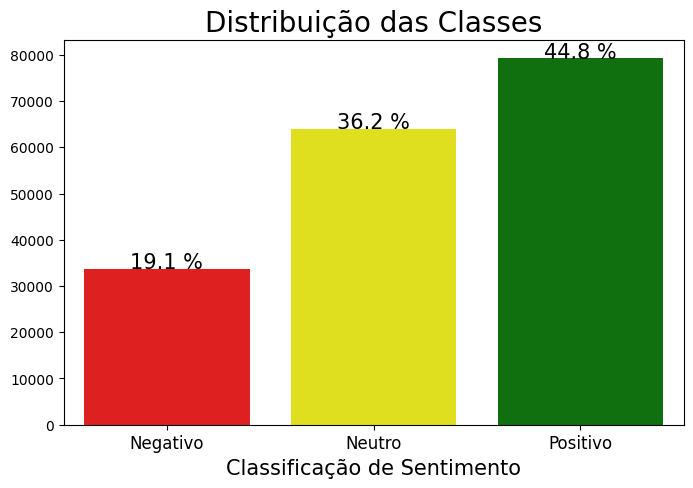

Distribuição quantitativa:
 feeling
2    79316
1    64040
0    33772
Name: count, dtype: int64

Distribuição percentual:
 feeling
2    0.447789
1    0.361546
0    0.190664
Name: proportion, dtype: float64


In [7]:
# Trecho de código oculto por já ter sido mostrado anteriormente

# Calcula a contagem e porcentagem das avaliações
rating_counts = dataset['feeling'].value_counts().sort_index().tolist()
rating_p = dataset['feeling'].value_counts(normalize=True).sort_index().mul(100).round(1).astype(str) + ' %'

palette = ['red', 'yellow', 'green']

# Plota o gráfico com as cores personalizadas e tamanho ajustado
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(x='feeling', data=dataset, hue='feeling', palette=palette, legend=False)
plt.xticks(fontsize=12, ticks=[0, 1, 2], labels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Distribuição das Classes', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Classificação de Sentimento', size=15)

# Adiciona os textos com as porcentagens
for i, v in enumerate(rating_counts):
    ax.text(i, v + 10, rating_p[i], ha='center', size=15, color='black')

plt.show()

print('Distribuição quantitativa:\n',dataset['feeling'].value_counts())
print('\nDistribuição percentual:\n', dataset['feeling'].value_counts(normalize=True))

### Pré-processamento do texto
Nessa seção a base de dados foi submetida a mais etapas de limpeza e tratamento, ainda com o objetivo de facilitar a obteção de bons resultados no treinamento. As etapas foram: 
* Conversão para minúsculas: todos os caracteres de todos os comentários são convertidos para letras minúsculas, para garantir consistência nos dados;
* Remoção de caracteres especiais: caracteres especiais, como emojis, são removidos para manter apenas o texto relevante. Acentos também são removidos, como a transformação da palavra "ação" em "acao";
* Remoção de números: os números são removidos usando expressões regulares, pois geralmente não são relevantes para a análise de texto;
* Remoção de pontuação: ajuda a limpar o texto e simplificar a _tokenização_;
* Remoção de espaços extras: espaços extras são removidos para garantir que o texto esteja bem formatado;
* Lematização* e remoção de _Stopwords_: cada _token_ é lematizado (reduzido à sua forma base) e as _stopwords_ são removidas para melhorar a precisão da análise.

<span style="font-size: smaller;">* **Lematização** é o processo de reduzir uma palavra à sua forma base, chamada lema. Por exemplo, as palavras "gato", "gata", "gatos" e "gatas" têm o mesmo lema: "gato". Isso é útil na análise de texto porque simplifica as palavras, permitindo que os modelos de linguagem entendam melhor o significado dos textos.</span><br>

In [8]:
# Criação da instância do lematizador e das stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('portuguese'))

# Lista para armazenar os textos pré-processados
preprocessed_texts = []

# Itera sobre cada texto no dataset para pré-processamento
for text in dataset['review_text']:
    # Verifica se o texto é uma string
    if isinstance(text, str):
        # Converte para minúsculas
        text = text.lower()
        # Remove acentos
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if unicodedata.category(char) != 'Mn')
        # Remove números usando expressão regular
        text = re.sub(r'\d+', '', text)
        # Remove caracteres especiais (incluindo emojis)
        text = re.sub(r'[^\w\s]', '', text)
        # Remove pontuação
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove espaços extras
        text = re.sub(r'\s+', ' ', text).strip()
        # Tokenização
        tokens = word_tokenize(text)
        # Lematização e remoção de stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word.lower() not in stop_words]
        # Junta os tokens em texto novamente
        preprocessed_text = ' '.join(tokens)
        # Adiciona o texto pré-processado à lista
        preprocessed_texts.append(preprocessed_text)
    else:
        preprocessed_texts.append("")

# Substitui os textos originais pelos textos já preparados para análise
dataset['review_text'] = preprocessed_texts

# Mostra a base de dados após o pré-processamento (10 primeiras linhas)
print("\nDataset após pré-processamento:")
dataset.head(10)


Dataset após pré-processamento:


,review_text,overall_rating,feeling
0,contente compra entrega rapida unico problema ...,4,2
1,apenas reu consegui comprar lindo copo acrilico,4,2
2,supera agilidade praticidade outras panelas el...,4,2
3,filho amou parece verdade tantos detalhes,4,2
4,entrega prazo americana estao parabens smart t...,5,2
5,excelente produto material acrilico super resi...,5,2
6,produto mto bom garrafinha vc pode ate servir ...,5,2
7,produto excelente qualidade boa camera desenvo...,4,2
8,barulho minimo vento bem forte velocidade,5,2
9,produto nao entregue americana descontando fat...,1,0


### Separação de dados
Separamos nossos dados, das colunas "_review_text_" (comentários das avaliações) e "_feeling_" (sentimentos), em **_features_ (X)** e **_target_ (Y)** respectivamente, para permite que o modelo seja treinado com as features (características, ou seja, o material que ele vai aprender a analisar) e as correspondentes _labels_ ou _targets_ (rótulos, que indicam ensinam o modelo o que cada comentário é, positivo, neutro ou negativo), aprendendo assim a fazer previsões ou classificações com base nos dados fornecidos.

* **_Features_ (X)**: são as características dos dados que o modelo utiliza para fazer previsões ou classificações. No caso, estamos utilizando os textos pré-processados como features, pois queremos que o modelo analise o texto para prever o sentimento associado a ele;
* **_Target_ (Y)**: é a variável que o modelo está tentando prever ou classificar. Neste caso, a variável target é 'feeling' (a coluna que guarda o sentimento do comentário), que representa o sentimento associado a cada texto (negativo, neutro ou positivo).



In [9]:
# Separa os dados em features (X) e target (Y)
X = dataset['review_text'].values
Y = dataset['feeling'].values


### Vetorização
Uma vez que o texto está pronto precisamos vetorizá-lo, ou seja, transformá-lo em números, pois é o formato que o modelo entende, portanto, apenas depois dessa etapa o treinamento se torna possível.   
Também foi utilizada uma técnica para melhorar o resultado do modelo, onde é analisada cada palavra individualmente, a junção de duas e três palavras (bigramas e trigramas) para identificar a classe, o que ajuda a capturar informações adicionais sobre a estrutura do texto, considerando não apenas palavras isoladas, mas também a relação entre elas.

In [10]:
# Cria um objeto CountVectorizer com N-grams, considerando unigramas, bigramas e trigramas
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))

# Transforma os textos em vetores numéricos, representando a frequência de ocorrência de cada palavra e combinação de palavras
X_ngrams = ngram_vectorizer.fit_transform(X)


## Treinamento e Validação do Modelo
Como já mencionado, estamos utilizando a biblioteca XGBoost para treinar um modelo capaz de classificar os sentimentos dos textos. Além disso, estamos aplicando uma técnica chamada **validação cruzada**, que é essencial para avaliar a capacidade do nosso modelo de generalizar para novos dados.

* A **validação cruzada** é uma prática onde dividimos nossos dados em partes iguais, chamadas *folds*, para treinar e testar o modelo em diferentes conjuntos de dados. No nosso caso, estamos dividindo nossos dados em 5 _folds_. Uma parte dos dados é usada para treinar o modelo, enquanto outra parte é reservada para testar sua capacidade de generalização.

In [11]:
# Cria uma instância do modelo XGBoost
xgboost = xgb.XGBClassifier()

# Especifica o número de folds para a validação cruzada
num_folds = 5

#  Cria um objeto StratifiedKFold para garantir que as classes estejam balanceadas em cada divisão
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lista para armazenar as pontuações de acurácia de cada divisão (fold)
accuracy_scores = []

# Realiza a validação cruzada
for train_index, test_index in kfold.split(X_ngrams, Y):
    # Separa os dados em conjuntos de treino e teste para esta divisão
    X_train, X_test = X_ngrams[train_index], X_ngrams[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Treina o modelo XGBoost com pesos de amostra
    xgboost.fit(X_train, Y_train)

    # Avalia o modelo com os dados de teste e armazenar a acurácia
    accuracy = xgboost.score(X_test, Y_test)
    accuracy_scores.append(accuracy)


## Resultados

### Acurácia
Foi calculado a média e o desvio padrão das pontuações de acurácia obtidas durante a validação cruzada. A média nos dá uma ideia geral do desempenho do nosso modelo, enquanto o desvio padrão indica o quanto as pontuações variam em relação à média. Isso nos ajuda a entender a consistência dos resultados em diferentes divisões dos dados. Um o desvio padrão baixo significa que as pontuações são consistentes e confiáveis.

In [12]:
# Calcula a média e o desvio padrão das pontuações de acurácia obtidas da validação cruzada
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Exibe os resultados da validação cruzada
print("Acurácia média:", mean_accuracy)
print("Desvio padrão da acurácia:", std_accuracy)


Acurácia média: 0.845315240519853
Desvio padrão da acurácia: 0.0010551173808451878


### Previsão das classes
Nessa etapa, estamos usando o modelo treinado para prever as classes de conjunto de comentários separado, que não foi usado durante o treinamento, chamado de conjunto de teste. Em seguida, criamos uma tabela que compara as previsões feitas pelo modelo com as classes reais dos comentários. Isso nos ajuda a entender quão preciso o modelo é em identificar os sentimentos.

In [13]:
# Cria um DataFrame (tabela com os dados) para comparar as previsões com as classes reais de "feeling"

df_results = pd.DataFrame({'Feeling_Predicted': Y_pred, 'Feeling_True': Y_test})
# Substitui os valores numéricos pelos seus equivalentes em texto
df_results['Feeling_Predicted'] = df_results['Feeling_Predicted'].replace({0: 'negativo', 1: 'neutro', 2: 'positivo'})
df_results['Feeling_True'] = df_results['Feeling_True'].replace({0: 'negativo', 1: 'neutro', 2: 'positivo'})

# Mostra os resultados dos 10 primeiros
print("\nResultados de 'feeling' após o treinamento do modelo:")
df_results


Resultados de 'feeling' após o treinamento do modelo:


,Feeling_Predicted,Feeling_True
0,negativo,positivo
1,neutro,positivo
2,positivo,positivo
3,positivo,neutro
4,positivo,positivo
...,...,...
35420,neutro,neutro
35421,neutro,neutro
35422,neutro,neutro
35423,neutro,neutro


### Matriz de confusão
É uma tabela que mostra a performance de um modelo de classificação. Cada linha representa as instâncias em uma classe real, enquanto cada coluna representa as instâncias em uma classe prevista pelo modelo. Os elementos na diagonal principal da matriz representam as previsões corretas, enquanto os elementos fora da diagonal principal são erros de classificação. Essa visualização ajuda a entender como o modelo está performando em cada classe.

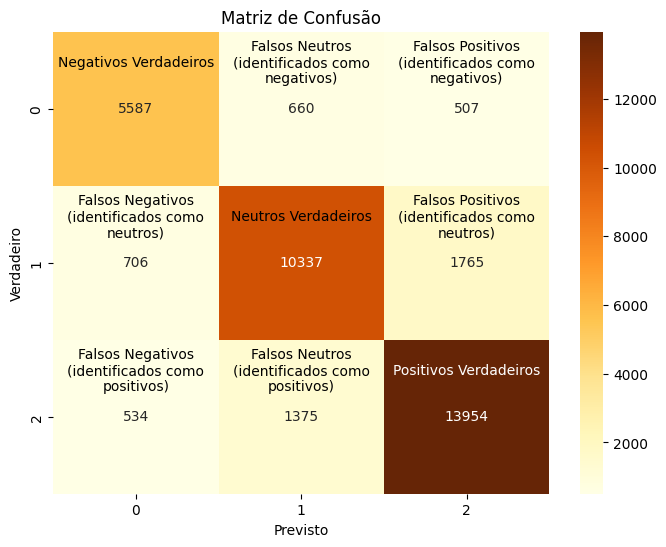

In [14]:
cm = confusion_matrix(Y_pred, Y_test)

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='YlOrBr', fmt='g')

# Adiciona legenda
plt.text(0.5, 0.2, 'Negativos Verdadeiros', color='black', ha='center', va='center')
plt.text(1.5, 0.2, 'Falsos Neutros\n(identificados como\nnegativos)', color='black', ha='center', va='center')
plt.text(2.5, 0.2, 'Falsos Positivos\n(identificados como\nnegativos)', color='black', ha='center', va='center')

plt.text(0.5, 1.2, 'Falsos Negativos\n(identificados como\nneutros)', color='black', ha='center', va='center')
plt.text(1.5, 1.2, 'Neutros Verdadeiros', color='black', ha='center', va='center')
plt.text(2.5, 1.2, 'Falsos Positivos\n(identificados como\nneutros)', color='black', ha='center', va='center')

plt.text(0.5, 2.2, 'Falsos Negativos\n(identificados como\npositivos)', color='black', ha='center', va='center')
plt.text(1.5, 2.2, 'Falsos Neutros\n(identificados como\npositivos)', color='black', ha='center', va='center')
plt.text(2.5, 2.2, 'Positivos Verdadeiros', color='white', ha='center', va='center')

# Define rótulos dos eixos
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')

plt.show()


### Avaliação de performance
Foram calculadas as métricas de avaliação para cada classe do nosso modelo de análise de sentimentos, sendo elas:
* Precisão (_Precision_): mede a proporção de exemplos positivos previstos corretamente em relação a todos os exemplos previstos como positivos. Ou seja, indica a qualidade das previsões positivas do modelo.

* _Recall_ (Sensibilidade): mede a capacidade do modelo de encontrar todos os exemplos positivos. É a proporção de exemplos positivos previstos corretamente em relação a todos os exemplos que são realmente positivos.

* F1-score: é a média da precisão e do recall, útil para avaliar a performance geral do modelo..

Essas métricas nos ajudam a entender como nosso modelo está performando para cada categoria, o que possibilita futuras melhorias.

In [15]:
# Calcula a precisão para cada classe
precision_negativo = precision_score(Y_test, Y_pred, average=None)[0]
precision_neutro = precision_score(Y_test, Y_pred, average=None)[1]
precision_positivo = precision_score(Y_test, Y_pred, average=None)[2]

# Calcula o recall para cada classe
recall_negativo = recall_score(Y_test, Y_pred, average=None)[0]
recall_neutro = recall_score(Y_test, Y_pred, average=None)[1]
recall_positivo = recall_score(Y_test, Y_pred, average=None)[2]

# Calcula o F1-score para cada classe
f1_negativo = f1_score(Y_test, Y_pred, average=None)[0]
f1_neutro = f1_score(Y_test, Y_pred, average=None)[1]
f1_positivo = f1_score(Y_test, Y_pred, average=None)[2]

# Exibe os resultados
print("Precisão para a classe Negativo:", precision_negativo)
print("Precisão para a classe Neutro:", precision_neutro)
print("Precisão para a classe Positivo:", precision_positivo)

print("\nRecall para a classe Negativo:", recall_negativo)
print("Recall para a classe Neutro:", recall_neutro)
print("Recall para a classe Positivo:", recall_positivo)

print("\nF1-score para a classe Negativo:", f1_negativo)
print("F1-score para a classe Neutro:", f1_neutro)
print("F1-score para a classe Positivo:", f1_positivo)


Precisão para a classe Negativo: 0.8183682437380987
Precisão para a classe Neutro: 0.8355156805690268
Precisão para a classe Positivo: 0.8599778133859238

Recall para a classe Negativo: 0.8272135031092686
Recall para a classe Neutro: 0.8070737039350406
Recall para a classe Positivo: 0.8796570636071361

F1-score para a classe Negativo: 0.8227671010971209
F1-score para a classe Neutro: 0.8210484511517077
F1-score para a classe Positivo: 0.8697061298264203


### Curva de ROC
Aqui vamos calcular as pontuações de probabilidade previstas para cada classe usando o método *predict_proba*. Em seguida, ele calcula a **Curva ROC** (*Receiver Operating Characteristic*) e a **AUC-ROC** (*Area Under the Curve of ROC*) para cada classe. 

A **Curva ROC** é uma representação gráfica da taxa de verdadeiros positivos em relação à taxa de falsos positivos para diferentes valores de threshold de classificação. 

Já a **AUC-ROC** é uma medida da capacidade do modelo de distinguir entre as classes. 

O código utiliza essas métricas para plotar as Curvas ROC para cada classe, com uma legenda indicando a área sob cada curva e os nomes das classes. A linha pontilhada representa a linha de base, indicando um classificador aleatório.

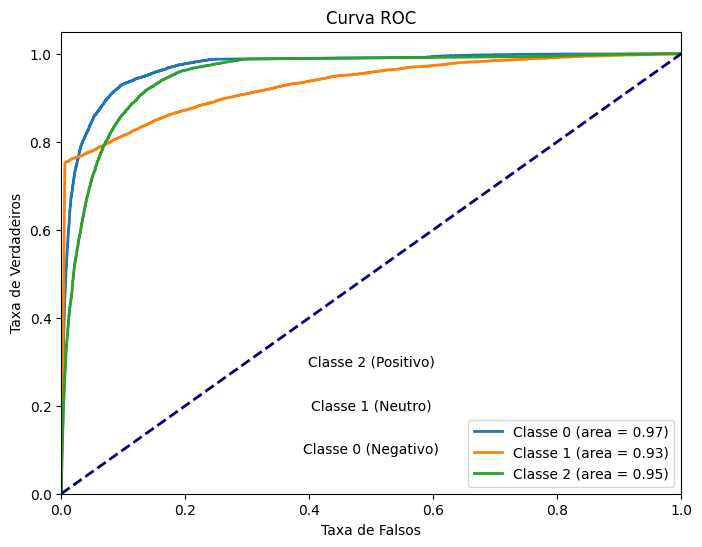

In [16]:
# Calcula as pontuações de probabilidade previstas para cada classe
y_scores = xgboost.predict_proba(X_test)

# Calcula a Curva ROC e a AUC-ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(xgboost.classes_)):
    fpr[i], tpr[i], _ = roc_curve(Y_test, y_scores[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot das Curvas ROC para cada classe com legenda
plt.figure(figsize=(8, 6))
for i in range(len(xgboost.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Classe {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos')
plt.ylabel('Taxa de Verdadeiros')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Adiciona legenda personalizada
class_legend = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}
for i in range(len(xgboost.classes_)):
    plt.text(0.5, 0.1 + i * 0.1, f"Classe {i} ({class_legend[i]})", color='black', ha='center', va='center')

plt.show()


### Melhoria dos resultados para classe 'Neutro'
Conforme citado no , obtivemos significativa melhoria nos resultados das métricas para os comentários neutros. Abaixo seguem os números alcançados com o treinamento usando o dataset original, seguido da melhoria alcançada (em variação percentual):

**Classe 'Neutro'**
* Precisão de ~0.28 para ~0.83, melhoria de ~296%
* Recall: ~0.57 para ~0.80, melhoria de ~140%
* F1-score: ~0.37 para ~0.82, melhoria de ~221%


## Exportação do modelo
Por fim, para viabilizar a utilização desse modelo no nosso projeto de dashboard (painel) de análise de sentimentos dos clientes, nosso modelo foi exportado em um arquivo com a biblioteca Joblib, salvo no mesmo diretório deste notebook.

In [17]:
# Salva o modelo e o vetorizador em um único arquivo chamado 'modelo_xg_boost.joblib'
dump((xgboost, ngram_vectorizer), 'modelo_xg_boost.joblib')

['modelo_xg_boost.joblib']